# A/B Testing

<img src="https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/ABTesting.png?raw=true" width=700>

*Photos/Images by [Optimizely](https://www.optimizely.com/insights/blog/how-obama-raised-60-million-by-running-a-simple-experiment/)*

## Overview

This chapter provides an introduction to A/B testing and the early peeking problem. The goal is that you understand the main principles of A/B testing that will allow you to properly design, run, and analyze data from A/B tests. While you probably know the main concepts behind A/B testing, the usage of online platforms to collect, store and analyze data from A/B tests open new challenges. For example, people get tempted to peek at results before the A/B test ended and take actions usually result in false discoveries. 


A/B Testing is a technique used to compare two variations of a product or service: control (A) and variation (B) 

- A/B testing became very popular in the context of updating and improving websites. 
    
It's main concepts are founded in the context of hypothesis testing and inference to compare population quantities from 2 distributions

- for example: comparison of two population means or population proportions
    

## Analysis Design

As in any other statistical anlaysis, important steps of an A/B testing experiment include,  

- post the *question(s)* you want to answer using data

- *design* the experiment to address your question(s)

- identify appropriate methodologies to analyze the data

- run the experiment to collect data 

- analyze the data according to the experimental design and make decisions


## Case study

### Obama's 60 million dollar experiment

In 2008, Obama's campaign was looking to increase the total amount of donations to the campaign. Organizers run an experiment to compare visitors' responses to different versions of the website.

<img src="https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/ABTesting.png?raw=true" width=700>

*A full description of this case study can be found [here](https://www.optimizely.com/insights/blog/how-obama-raised-60-million-by-running-a-simple-experiment/).*


While there is not a unique way to design an A/B testing experiment, ***randomized controlled experiments*** are commonly used in practice. When participants are randomly assigned to the experimental group or the control group, you only expect to observe differences driven by the controlled effect (e.g., a new website) and not by other confounding factors. 

Other decisions need to be made when designing an A/B testing experiment, including sample size, number of tests, methodology. Since the choices made would influence the results, companies usually run some calibration tests before running the actual experiment. 

```{admonition} Example

**Question**: Does visitors of the new website contribute with larger donations for the political campaign?  

**Design**: Randomly allocate 1000 visitors to each website (control and new)

**Method**: Analyze the data sequentially in batches of 50 visitors per website. Use a classical $t$-test to run the analysis, compute $p$-values and confidence intervals

**Decision**: Stop the experiment if the $p$-value of a test drops below a significance level of $0.05$
```

So, what is new about A/B testing?

## Early stopping

New platforms have been developed to assist companies to analyze, report and visualize the results of their experiments **in real time**

<img src="https://miro.medium.com/max/1400/1*W8mUB5A96ufsbMWLqScVOA.png" width=600>

<font color=grey>Figure by D. Meisner in Towards Data Science </font>

These platforms allow the users to *continuously monitor* the $p$-values and confidence intervals in order to re-adjust their experiment dynamically. 

```{caution}
In classical hypothesis testing theory, the sample size must be fixed in advance when the experiment is designed!! Is it ok to peek at results before all the data are collected??
```

In general, there are large opportunity costs associated with longer experiments. Thus, users may prefer to adaptively determine the sample size of the experiments and make decisions before the planned experiment ends. 

```{admonition} Definition
:class: tip
**Early stopping** refers to ending the experiment earlier than originally designed.
```

Can we stop or re-design the experiment earlier if we have supporting evidence to do so?? Let's answer this question using data!

### A/A Testing
To examine the problem of early stopping, let's simulate data for which $H_0$ is true (i.e., there is no effect)

```{admonition} Example
All users are allocated to the same version of a website.
```
  
<img src="https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/aa-Obama.png?raw=true" width=600>

In such a scenario, data from both groups are generated from the same distribution. Thus, we know that rejecting $H_0$  is a mistake! 

```{admonition} Simulation Example

- generate 1000 data points per group (control and variation) from the same distribution (total sample size of 2000) 

- sequentially analyze the data in batches of 50 observations per group using a two-sample $t$-tests

- sequentially compute and monitor the (raw) $p$-values 

- reject the null hypothesis if a $p$-value drops below $0.05$ and stop the experiment.  

```

Simulating this kind of data and running the same analysis many times allows you examine the properties of the procedure used. For example, you can estimate the type I error rate by counting in how many experiments the $p$-value has dropped below the significance level and you erroneously reject the null hypothesis

```{admonition} Wrong Rejection
:class: caution
The data were generated from the same distribution (e.g., all users are allocated to the same version of a website). Thus, in principle, the $p$-value should not drop below 0.05. However, due to randomness, you may still find significant differences between the two groups. But how often does that occur?? 
```

Let's start by simulating one such experiments and visualizing the results.

In [1]:
options(warn=-1)
options(messages=-1)
library(tidyverse)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──



✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0



── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



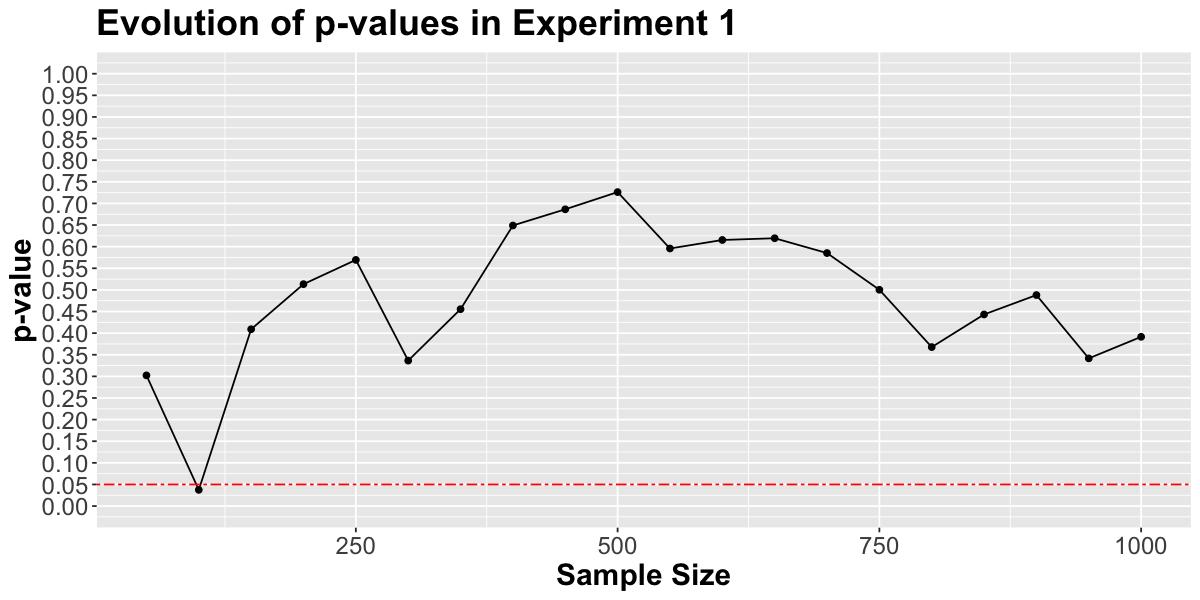

In [2]:
# FUNCTION
# Two-sample t-test with tracking sequential statistic and p-values by incremental sample sizes until getting to n in each group.

# @param n (numeric): Initially planned sample size for each group (for simplicity, n needs to be a multiple of sample_increase_step).
# @param d_0 (numeric): effect size.
# @param mean_current (numeric): Population mean for control variation.
# @param sd_current (numeric): Population standard deviation for current variation.
# @param sd_new (numeric): Population standard deviation for new variation.
# @param sample_increase_step (numeric): Sample size increment.

# @return p.value.df: A tibble that has 3 columns:
# inc_sample_size, statistic, and p_value 

incremental_t_test <- function(n, d_0, mean_current, sd_current, sd_new, sample_increase_step) {
  sample_current <- rnorm(n, mean = mean_current, sd = sd_current)
  sample_new <- rnorm(n, mean = mean_current + d_0, sd = sd_new)

  p.value.df <- tibble(
    inc_sample_size = rep(0, n / sample_increase_step),
    statistic = rep(0, n / sample_increase_step),
    p_value = rep(0, n / sample_increase_step)
  )

  current_sample_size <- sample_increase_step
  
  for (i in 1:nrow(p.value.df))
  {
    t_test_results <- t.test(sample_new[1:current_sample_size], sample_current[1:current_sample_size],
      var.equal = TRUE,
      alternative = "greater"                      
    )
    p.value.df[i, "statistic"] <- as_tibble(t_test_results$statistic)
    p.value.df[i, "p_value"] <- as_tibble(t_test_results$p.value)
    p.value.df[i, "inc_sample_size"] <- current_sample_size
    current_sample_size <- current_sample_size + sample_increase_step
  }

  return(p.value.df)
}

#---------------------------------------------------------------

#TEST and PLOT

options(repr.plot.width = 10, repr.plot.height = 5) 
options(warn=-1)

set.seed(301)
answer2.1 <- 
    incremental_t_test(n = 1000, d_0 = 0, sample_increase_step = 50, mean_current = 200, sd_current = 50, sd_new = 50)

sequential_pvalue <- 
  answer2.1 %>%
  ggplot() +
  geom_line(aes(x = inc_sample_size, y = p_value)) +
  theme(
    text = element_text(size = 18),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) + 
  geom_point(aes(x = inc_sample_size, y = p_value)) +
  ggtitle("Evolution of p-values in Experiment 1") +
  ylab("p-value") +
  xlab("Sample Size") +
  geom_hline(
    yintercept = 0.05,
    colour = "red",
    linetype = "twodash"
  ) +
  coord_cartesian(ylim = c(0, 1)) +
  scale_y_continuous(breaks = seq(0, 1, by = 0.05))

sequential_pvalue

### Interpretation

After collecting data from 100 participants the $p$-value drops below $0.05$ so the experiment is stopped. But we know that claiming a significance difference in this experiment is a mistake.

```{admonition} Example
Changing the website is costly and may not really increase the size of the donations as expected
```

But, isn't this mistake one potential result of the test? 

```{admonition} Definition
:class: tip
In statistical hypothesis testing, rejecting $H_0$ when it is true is known as the **type I error**. The probability of a type I error is equal to the significance level of the test.
```

In our example, the test was planned so that the probability to falsely rejecting $H_0$ is 5%. So, why is this a problem??

```{admonition} Type I error rate inflation
:class: caution
The problem is that the probability of falsely rejecting $H_0$ may be larger than expected! 
```

To know if the probability of falsely rejecting $H_0$ is larger than 5%, we need to run *many* of these experiments!!

The figure below shows the p-value trajectory of 100 experiments. We see that the p-values of more than 5% of the experiments are below the significance level. 


<center>
<img src="https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/aa-Obama-pval100.png?raw=true" width=900>
</center>

```{important}
It can be proved, mathematically, that under the null hypothesis, the classical $p$-value will *always* cross $\alpha$ if the experimenter waits long enough$^{*}$. This means that with increasing data, the probability of falsely rejecting a true $H_0$ approaches to 1!
```

[*] David Siegmund. 1985. Sequential analysis: tests and confidence intervals.
Springer.

## Summary and key concepts learned 

1. A/B testing refers to an experiment, in which users are randomly assigned to one of two variations of a product or service: control (A) and variation (B) to see if variation B should be used for improvement.


2. The statistic used to test a hypothesis, the sample size calculation, the type I error rate specification and the desired power are all important and interconnected pieces of the experimental design! 


3. In classical hypothesis testing theory, the sample size must be fixed in advance when the experiment is designed!!


4. Modern platforms allow the users to continuously monitor the p-values and confidence intervals of their tests as data are collected (peeking) in order to re-adjust their experiment dynamically. 


5. Stopping an experiment and rejecting $H_0$ as soon as the $p$-value is below the specified significance level can drastically inflate the type I error rate

```{attention} 
Controlling the risk of wrongly rejecting the null hypothesis is not an easy task in A/B testing if peeking and early stops are allowed!
```